## Astronomy 406 "Computational Astrophysics" (Fall 2024)

## Project 8: 

### Michael Struk

In [1]:
### Importing Libraries ###

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('mplstyle.txt')

from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse

from sklearn.mixture import GaussianMixture
from sklearn import neighbors, svm, ensemble
from sklearn.model_selection import cross_val_score

cmap_bold = ListedColormap(['#0000FF', '#00FF00', '#FF0000'])
cmap_light = ListedColormap(['#AAAAFF', '#AAFFAA', '#FFAAAA'])

# To avoid warnings from GMM
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings('ignore')

# Function for ellipses
def draw_ellipse(mu, C, scales=[1,2], **kwargs):

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    # scale is number of "sigma"s
    for scale in scales:
        plt.gca().add_patch(Ellipse(mu, 2 * scale * sigma1, 2 * scale * sigma2,
                             angle = alpha * 180. / np.pi, **kwargs))

### Tasks

1. Select galaxies in the SDSS galaxy catalog in the redshift range $0.03 < z < 0.04$ (you should obtain 27,466 objects). For these objects assemble a dataset array $X$ with 5 properties: $r$, $g-r$, SB, sSFR, and $D_n$.<br>

In [2]:
## Reading in and selecting data ##

if True:
    from astroML.datasets import fetch_sdss_specgals
    data = fetch_sdss_specgals()
else:
    from astropy.io.fits import getdata
    data = getdata('SDSSspecgalsDR8.fit',1)

In [3]:
# Redshift cut 
sample = np.logical_and(data['z'] > 0.03, data['z'] < 0.04).flatten()
dat = data[sample]
print(len(dat), 'objects')

# r-band magnitude and g-r color
r = dat['modelMag_r'].flatten()

# g-r color
gr = (dat['modelMag_g'] - dat['modelMag_r']).flatten()

# Surface brightness in magnitudes per square arcsec
size = dat['petroR50_r'].flatten()
SB = r - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2)

# specific Star formation rate SFR/Mstars
sSFR = (dat['sfr_tot_p50']+9 - dat['lgm_tot_p50']).flatten()

# Phenomenological proxy for age of stars
Dn = dat['d4000'].flatten()

# Dataset array assembly: 
#             0  1  2   3   4
X = np.array([r,gr,SB,sSFR,Dn]).T

27466 objects


In [4]:
X.shape

(27466, 5)

2. Run GMM on this 5-dimensional dataset, with about 10 groups. Much larger than 10 may make the next step cumbersome and longer to compute, and fewer than 10 may not cover the full shape of the distribution. The default convergence criterion in `GaussianMixture` is quite weak, so I suggest to use stricter tolerance parameter, at least `tol=1e-9`. If you get pink warning statements, you may need to increase the maximum number of iterations `max_iter`.<br>

In [5]:
# run GMM implementation with 10 groups
ngroups = 10
gmm = GaussianMixture(n_components=ngroups, random_state=0, tol=1e-9, covariance_type='full').fit(X)

# collect the group assignments

assignments = gmm.predict(X)
groups = [[],[],[],[],[],[],[],[],[],[]]

for group in range(ngroups):
    groups[group].append(np.where(assignments==group))


3. Combine the groups identified by GMM into two classes of red and blue galaxies as seems reasonable based on our previous experience. Once you decide which groups should comprise class 1 and which groups class 0, create a 1D array $T$ that has the class labels for all galaxies based on their predicted group numbers $g_i$. In the end this array $T$ should have values 1 or 0 and be of same length as the number of galaxies in $X$. You can also choose alternative labels if you prefer, for example `True` and `False`, or `'red'` and `'blue'`.<br>


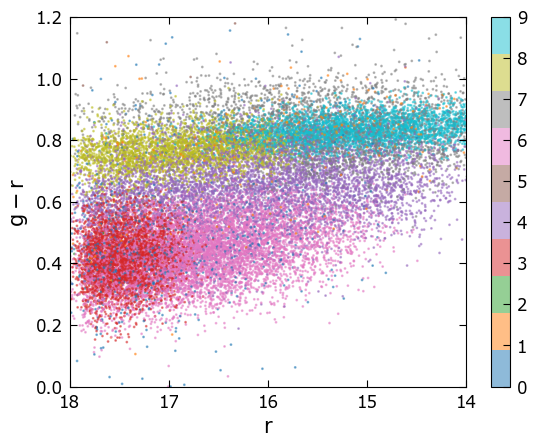

In [6]:
# Visualize the groups
plt.scatter(X[:,0], X[:,1], c=assignments, cmap='tab10', alpha=0.5, s=1)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$')
plt.ylabel(r'${\rm g - r}$')
plt.colorbar()
plt.show()

In [7]:
# class definitions
gr_lim = 0.65
sSFR_lim = -2
SB_lim = 21
Dn_lim = 1.7

# initialize T array
T = np.zeros_like(assignments)
# implement the classes
for group in range(ngroups):
    if (gmm.means_[group][1] > gr_lim) and (gmm.means_[group][3] < sSFR_lim):
        T[groups[group]]=0
    else:
        T[groups[group]]=1
red = np.where(T==0)
blue = np.where(T==1)
print('T array length', len(T))

T array length 27466


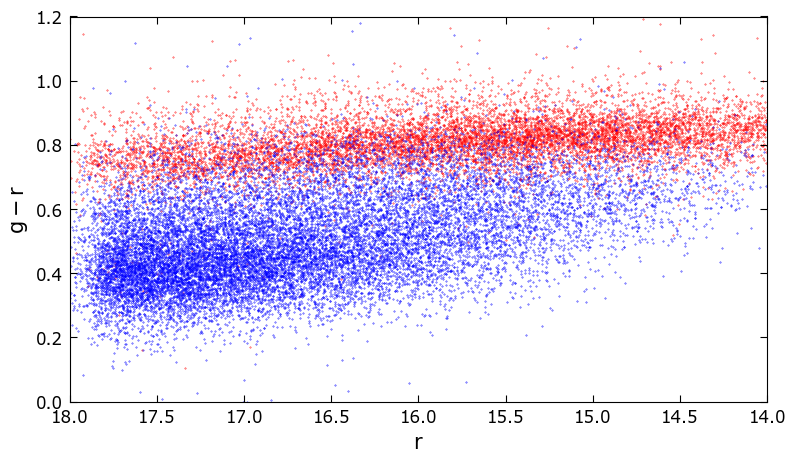

In [8]:
# visualize the GMM red/blue groups
plt.figure(figsize=(9,5))
plt.scatter(X[:,0][red], X[:,1][red], c='r', s=.1)
plt.scatter(X[:,0][blue], X[:,1][blue], c='b', s=.1)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$')
plt.ylabel(r'${\rm g - r}$')
plt.show()

4. Select galaxies with the probability of belonging to some group greater than 90%. I find approximately 12,000 galaxies to satisfy this criterion. Your numbers may differ depending on the GMM split you choose. Let's call this subset $X_u$.<br>

In [9]:
# Get probabilities for each group
probs = gmm.predict_proba(X)

# Get the probability of points belonging to the predicted group
gmm_predict_probs = probs[np.arange(len(assignments)), gmm.predict(X)]

print("Predicted groups:\n", assignments)
print("Probabilities for points being in predicted groups:\n", gmm_predict_probs)

# select sufficient probabilities
gd_prob = np.where(gmm_predict_probs > 0.9)
Xu = X[gd_prob]
Tu = T[gd_prob]
print('\nNumber of points with p>0.9:',len(Xu))

# create color list of Tu
colorsTu = ['red' if label == 0 else 'blue' for label in Tu]

Predicted groups:
 [4 7 4 ... 6 7 7]
Probabilities for points being in predicted groups:
 [0.94416552 0.99629414 0.7815478  ... 0.82302378 0.98973062 0.62532538]

Number of points with p>0.9: 10623


5. Make plots of the $g-r$ color vs. the other four variables, for the galaxies in $X_u$, colored according to their labels $T_u$. In each panel overplot the GMM ellipses corresponding to the identified groups. The plots can be made nicer by showing only the ellipses of the groups with a significant fraction of objects, for example, above 10%; groups containing few objects can be ignored for clarity. Verify visually that the ellipses correspond to the assigned labels.<br>


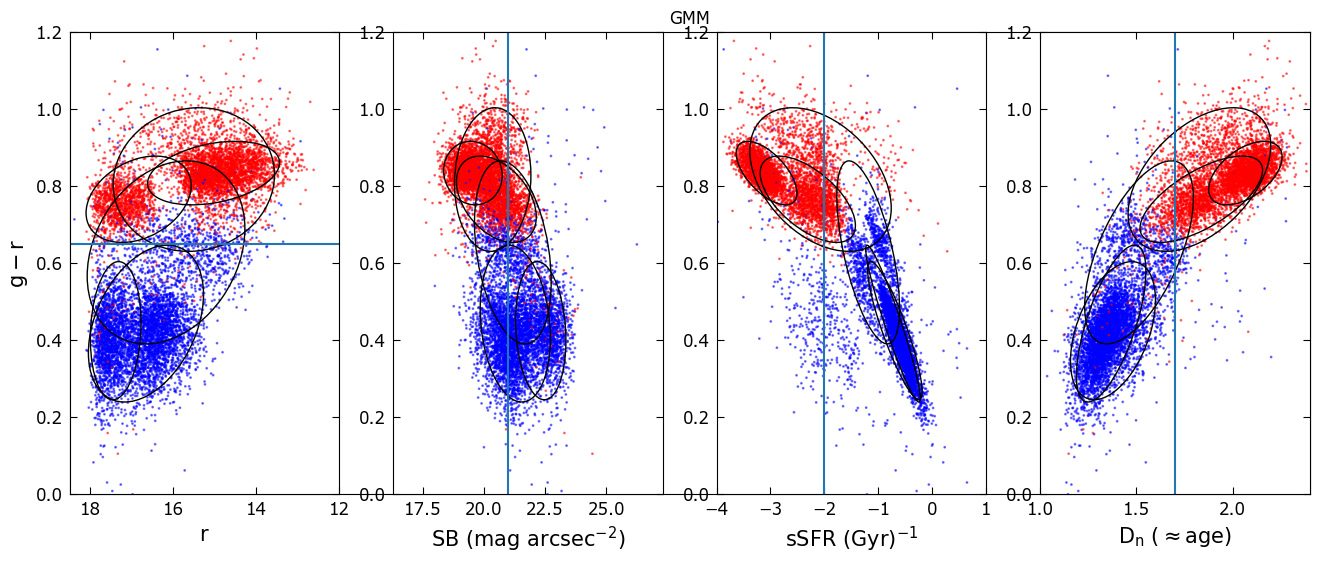

In [10]:
# visualize each of g-r vs. other variables with ellipses (10%+ significance)

plt.figure(figsize=(16,6))
plt.title('GMM')
plt.yticks([])
plt.xticks([])

plt.subplot(1,4,1)
plt.scatter(Xu[:,0], Xu[:,1], c=colorsTu, alpha=0.5, s=1)
plt.axhline(gr_lim)
plt.xlim(18.5, 12)
plt.ylim(0,1.2)
plt.ylabel(r'${\rm g - r}$')
plt.xlabel(r'${\rm r}$')
for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    if w > 0.1:
        draw_ellipse(mu, C, scales=[2], fc='none', ec='k')

plt.subplot(1,4,2)
plt.scatter(Xu[:,2], Xu[:,1], c=colorsTu, alpha=0.5, s=1)
plt.ylim(0,1.2)
plt.axvline(SB_lim)
plt.xlabel(r'$\mathrm{SB\ (mag\ arcsec^{-2})}$')
for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    if w > 0.1:  # plot only groups with >10% weight
        mu_plot = mu[[2,1]]  # extract mean for SB and g - r
        C_plot = C[np.ix_([2,1], [2,1])]  # extract covariance for SB and g - r
        draw_ellipse(mu_plot, C_plot, scales=[2], fc='none', ec='k')


plt.subplot(1,4,3)
plt.scatter(Xu[:,3], Xu[:,1], c=colorsTu, alpha=0.5, s=1)
plt.axvline(sSFR_lim)
plt.xlim(-4, 1)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm sSFR\ (Gyr)^{-1}}$')
for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    if w > 0.1:
        mu_plot = mu[[3,1]]  # Extract mean for sSFR and g - r
        C_plot = C[np.ix_([3,1], [3,1])]  # Extract covariance for sSFR and g - r
        draw_ellipse(mu_plot, C_plot, scales=[2], fc='none', ec='k')

plt.subplot(1,4,4)
plt.scatter(Xu[:,4], Xu[:,1], c=colorsTu, alpha=0.5, s=1)
plt.axvline(Dn_lim)
plt.xlim(1, 2.4)
plt.ylim(0,1.2)
plt.xlabel(r'$\mathrm{D_n\ (\approx age)}$')
for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    if w > 0.1:
        mu_plot = mu[[4,1]]  # Extract mean for D_n and g - r
        C_plot = C[np.ix_([4,1], [4,1])]  # Extract covariance for D_n and g - r
        draw_ellipse(mu_plot, C_plot, scales=[2], fc='none', ec='k')


plt.show()



> The ellipses describe the groupings of galaxies well.

6. Now we can run supervised classifiers on our dataset $X_u$ with known labels $T_u$. Split $X_u$ into a training set (70% of objects) and a test set (30% of objects). Then train each of the following classifiers discussed in Weeks 11 and 12 notebooks: [Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html), [Support Vector Machines](http://scikit-learn.org/stable/modules/svm.html), and [Random Forest](http://scikit-learn.org/stable/modules/ensemble.html#forest) on the training set.<br>

In [11]:
print('total dataset:', Xu.shape, 'galaxies')

# ~70% training set
Xtraining = Xu[:7000]
print('training set:', len(Xtraining), 'galaxies')

# ~30% test set
Xtest = Xu[-3000:]
print('test set:', len(Xtest), 'galaxies')

total dataset: (10623, 5) galaxies
training set: 7000 galaxies
test set: 3000 galaxies


#### In the following two sections of cells, the target boundaries are defined in different ways to compare and contrast the results. 

#### The first is using both the color cut and specific star formation rate cut, and the second is only the color cut.

## First target definition
##### $(g-r)>0.65$ and sSFR$<-2$

In [12]:
# define target
Ttraining = (Xtraining[:,1] > gr_lim) & (Xtraining[:,3] < sSFR_lim)#& (Xtraining[:,4] > Dn_lim) & (Xtraining[:,2] < SB_lim) # 
Ttest = (Xtest[:,1] > gr_lim) & (Xtest[:,3] < sSFR_lim) #& (Xtest[:,4] > Dn_lim) & (Xtest[:,2] < SB_lim) #

# KNN classifier
clfKNN = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='manhattan')

# evaluate fit
clfKNN.fit(Xtraining, Ttraining)

# apply fit to the test data
yKNN = clfKNN.predict(Xtest)

# create color list of yKNN
colorsKNN = ['red' if label == True else 'blue' for label in yKNN]

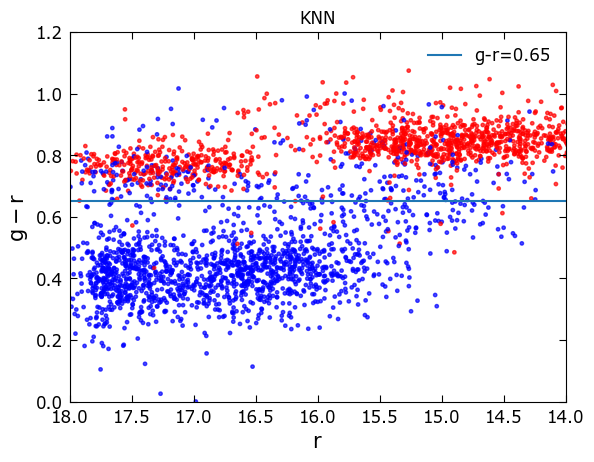

In [13]:
# plotting KNN results
plt.scatter(Xtest[:,0], Xtest[:,1], c=colorsKNN, alpha=0.7, s=6)

plt.axhline(gr_lim, label='g-r=0.65')

plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$')
plt.ylabel(r'${\rm g - r}$')
plt.legend()
plt.title('KNN');

In [14]:
# SVC classifier
clfSVC = svm.SVC(kernel='rbf', gamma='auto')

# evaluate fit
clfSVC.fit(Xtraining, Ttraining)

# apply fit to the test data
ySVC = clfSVC.predict(Xtest)

# Using list comprehension to create color list of ySVC
colorsSVC = ['red' if label == True else 'blue' for label in ySVC]

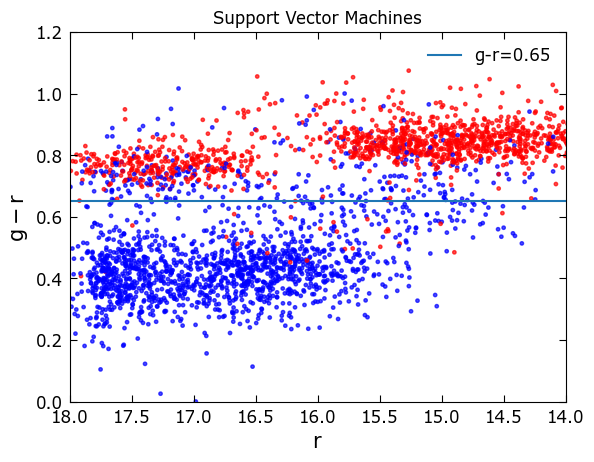

In [15]:
# plotting SVC results
plt.scatter(Xtest[:,0], Xtest[:,1], c=colorsSVC, alpha=0.7, s=6)

plt.axhline(gr_lim,label='g-r=0.65')

plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$')
plt.ylabel(r'${\rm g - r}$')
plt.legend()
plt.title('Support Vector Machines');

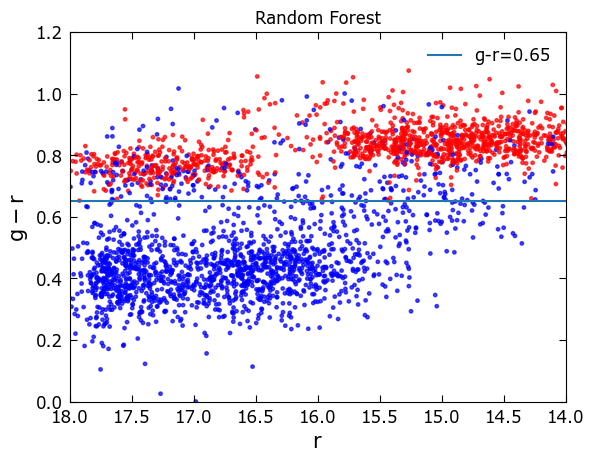

In [16]:
# Random Forest classifier
clfRF = ensemble.RandomForestClassifier(n_estimators=150)

# evaluate fit 
clfRF.fit(Xtraining, Ttraining)

# apply fit to the test data
yRF = clfRF.predict(Xtest)

# Using list comprehension to create color list of yRF
colorsRF = ['red' if label == True else 'blue' for label in yRF]

# plotting RF results
plt.scatter(Xtest[:,0], Xtest[:,1], c=colorsRF, cmap=cmap_bold, alpha=0.7, s=6)

plt.axhline(gr_lim,label='g-r=0.65')

plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$')
plt.ylabel(r'${\rm g - r}$')
plt.legend()
plt.title('Random Forest');

7. Use [k-fold cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) on the same training set to determine the best values of hyperparameters (optional arguments) for each of the three classifiers. You don't need to run any sophisticated optimizations, just try several values and functional forms and see what works best.<br>

In [17]:
# cross-validation scores for each classifier

# KNN
scoreKNN = cross_val_score(clfKNN, Xtraining, Ttraining, cv=5)
print('KNN',scoreKNN)

# SVM
scoreSVC = cross_val_score(clfSVC, Xtraining, Ttraining, cv=5)
print('SVM',scoreSVC)

# RF
scoreRF = cross_val_score(clfRF, Xtraining, Ttraining, cv=5)
print('RF',scoreRF)

KNN [0.98214286 0.97928571 0.985      0.97714286 0.98928571]
SVM [0.99071429 0.98571429 0.99071429 0.97785714 0.99071429]
RF [1.         1.         1.         1.         0.99928571]


8. Run all three classifiers with their best hyperparameters to predict labels for the test dataset and test the actual accuracy of classification. Compare the performance of the three methods.<br>

In [18]:
# collect names of classifiers
names = ["Nearest Neighbors", "rbf SVM", "Random Forest"]

# collect classifiers
classifiers = [
    neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan'),
    svm.SVC(kernel='rbf', gamma='auto'),
    ensemble.RandomForestClassifier(n_estimators=150, max_depth=3)
]

# check accuracy of classification against test target
for name, clf in zip(names, classifiers):
    
    clf.fit(Xtraining, Ttraining)
    
    score = clf.score(Xtest, Ttest)
    print('%s: %6.4f' % (name, score))

Nearest Neighbors: 0.9837
rbf SVM: 0.9823
Random Forest: 0.9997


> The rbf SVM had the lowest score, followed by KNN, and RF having the highest at effectively ~1.

9. Finally, use the trained classifiers to predict labels for the galaxies not selected in the set $X_u$, that is, all those with the group membership probability below 90%. Make plots of the 4 variable panels ($g-r$ vs. $r$, SB, sSFR, $D_n$) for each classifier for these galaxies, with the colors according to their predicted labels. Compare the result with the simple splits based on a single variable used in the Week 12 notebook, and discuss similarities and differences.

In [19]:
# select bad probabilities
bd_prob = np.where(gmm_predict_probs <= 0.9)
Xnu = X[bd_prob]
Tnu = T[bd_prob]

# predict assignments with trained models on new set
yKNN2 = clfKNN.predict(Xnu)
ySVC2 = clfSVC.predict(Xnu)
yRF2 = clfRF.predict(Xnu)

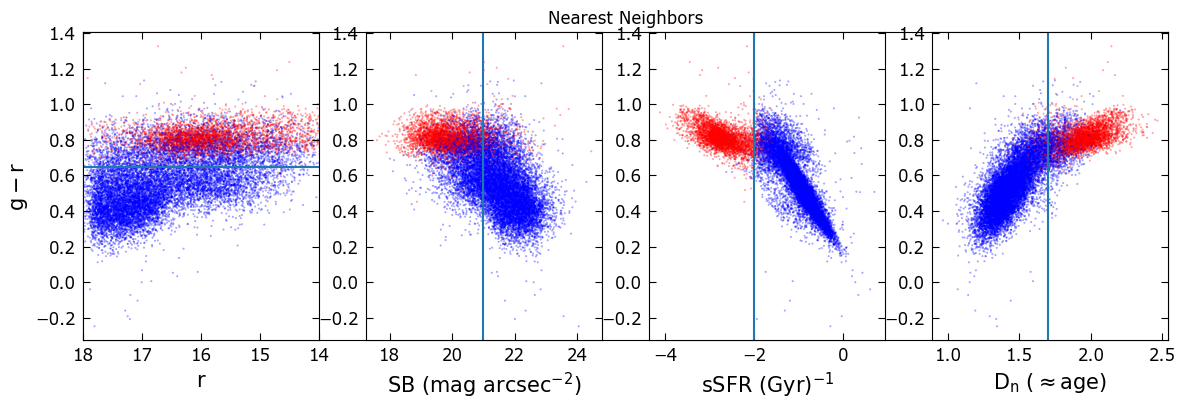

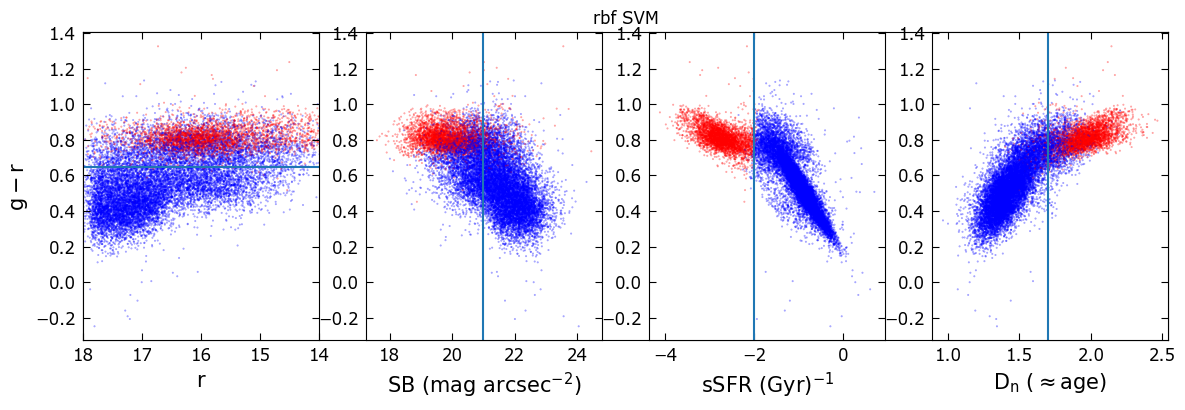

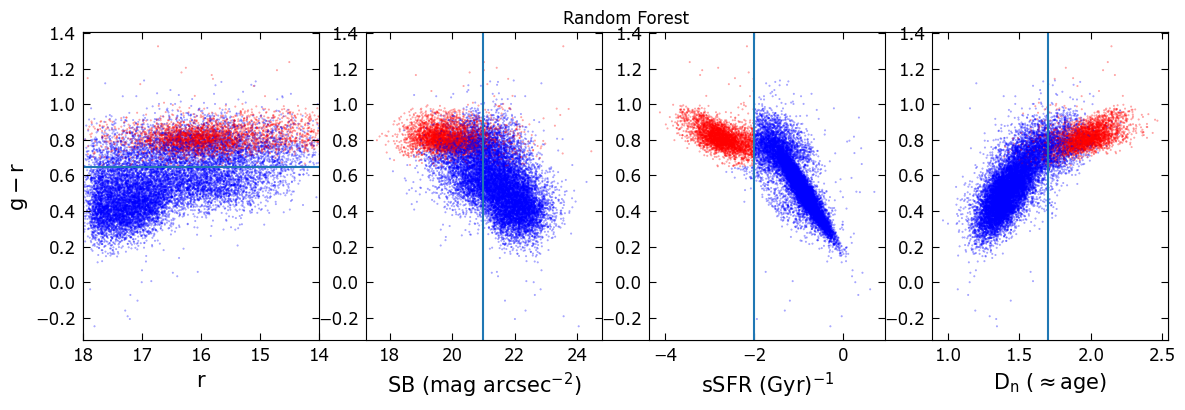

In [20]:
# Using list comprehension to create color list of yRF
colorsKNN2 = ['red' if label == True else 'blue' for label in yKNN2]
colorsSVC2 = ['red' if label == True else 'blue' for label in ySVC2]
colorsRF2 = ['red' if label == True else 'blue' for label in yRF2]

gd_colors = [colorsKNN2, colorsSVC2, colorsRF2]

for clf, name in zip(gd_colors, names):
    plt.figure(figsize=(14,4))
    plt.title(f'{name}')
    plt.yticks([])
    plt.xticks([])
    for i, plot in zip([0,2,3,4], [1,2,3,4]):
        plt.subplot(1,4, plot)
        plt.scatter(Xnu[:,i], Xnu[:,1], c=clf, alpha=0.4, s=0.2)
        plt.xlabel(r'${\rm r}$')
        if i == 0:
            plt.xlim(18,14)
            # plt.ylim(0,1.2)        
            plt.ylabel(r'${\rm g - r}$')
            plt.axhline(gr_lim)
        if i == 2:
            # plt.ylim(0,1.2)
            plt.axvline(21)
            plt.xlabel(r'$\mathrm{SB\ (mag\ arcsec^{-2})}$')
        if i == 3:
            # plt.xlim(-4, 1)
            # plt.ylim(0,1.2)
            plt.axvline(-2)
            plt.xlabel(r'${\rm sSFR\ (Gyr)^{-1}}$')
        if i == 4:
            # plt.xlim(1, 2.4)
            # plt.ylim(0,1.2)
            plt.axvline(1.7) 
            plt.xlabel(r'$\mathrm{D_n\ (\approx age)}$')

    plt.show()
    print()

### Second target definition
##### $(g-r)>0.65$

In [21]:
Ttraining = (Xtraining[:,1] > gr_lim) #& (Xtraining[:,3] < sSFR_lim)#& (Xtraining[:,4] > 1.8) & (Xtraining[:,2] < 21) # 
Ttest = (Xtest[:,1] > gr_lim) #& (Xtest[:,3] < sSFR_lim) #& (Xtest[:,4] > 1.8) & (Xtest[:,2] < 21) #

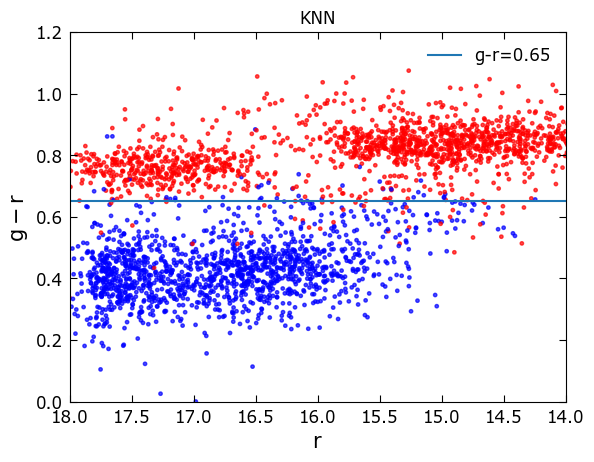

In [22]:
# KNN
clfKNN = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='manhattan')
clfKNN.fit(Xtraining, Ttraining)
yKNN = clfKNN.predict(Xtest)

colorsKNN = ['red' if label == True else 'blue' for label in yKNN]

plt.scatter(Xtest[:,0], Xtest[:,1], c=colorsKNN, alpha=0.7, s=6)
plt.axhline(gr_lim, label='g-r=0.65')

plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$')
plt.ylabel(r'${\rm g - r}$')
plt.legend()
plt.title('KNN');

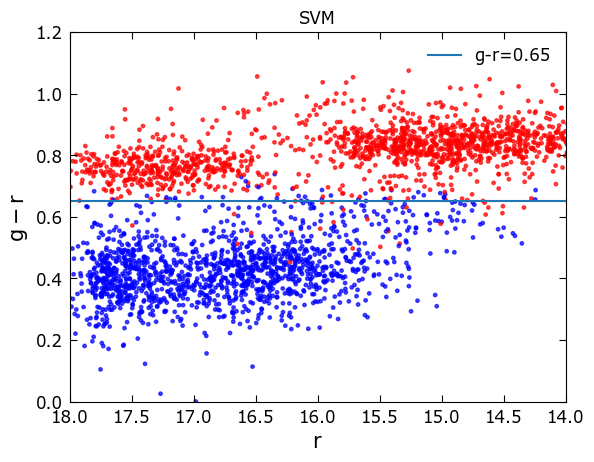

In [23]:
# SVM
clfSVC = svm.SVC(kernel='rbf', gamma='auto')
clfSVC.fit(Xtraining, Ttraining)
ySVC = clfSVC.predict(Xtest)

colorsSVC = ['red' if label == True else 'blue' for label in ySVC]

plt.scatter(Xtest[:,0], Xtest[:,1], c=colorsSVC, alpha=0.7, s=6)

plt.axhline(gr_lim,label='g-r=0.65')

plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$')
plt.ylabel(r'${\rm g - r}$')
plt.legend()
plt.title('SVM');

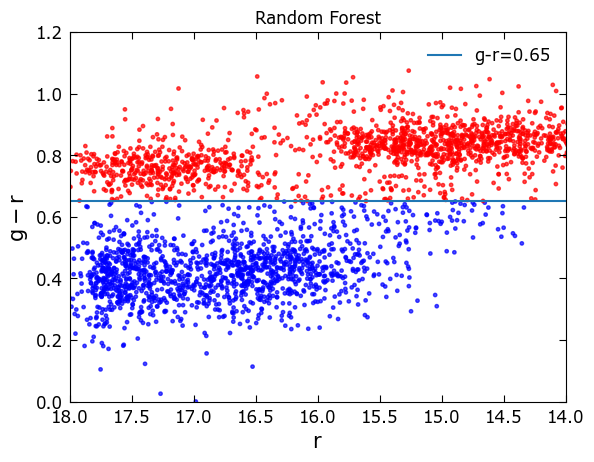

In [24]:
# Random Forest
clfRF = ensemble.RandomForestClassifier(n_estimators=150)
clfRF.fit(Xtraining, Ttraining)
yRF = clfRF.predict(Xtest)

colorsRF = ['red' if label == True else 'blue' for label in yRF]

plt.scatter(Xtest[:,0], Xtest[:,1], c=colorsRF, cmap=cmap_bold, alpha=0.7, s=6)
plt.axhline(gr_lim,label='g-r=0.65')

plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$')
plt.ylabel(r'${\rm g - r}$')
plt.legend()
plt.title('Random Forest');

In [25]:
# cross-validation
scoreKNN = cross_val_score(clfKNN, Xtraining, Ttraining, cv=5)
print('KNN',scoreKNN)

scoreSVC = cross_val_score(clfSVC, Xtraining, Ttraining, cv=5)
print('SVM',scoreSVC)

scoreRF = cross_val_score(clfRF, Xtraining, Ttraining, cv=5)
print('RF',scoreRF)

KNN [0.97357143 0.97857143 0.97285714 0.95571429 0.97285714]
SVM [0.98       0.97714286 0.97428571 0.96571429 0.96928571]
RF [0.99928571 1.         0.99928571 1.         1.        ]


In [26]:
# accuracy check
names = ["Nearest Neighbors", "rbf SVM", "Random Forest"]

classifiers = [
    neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan'),
    svm.SVC(kernel='rbf', gamma='auto'),
    ensemble.RandomForestClassifier(n_estimators=150, max_depth=3)
]

for name, clf in zip(names, classifiers):
    clf.fit(Xtraining, Ttraining)
    score = clf.score(Xtest, Ttest)
    print('%s: %6.4f' % (name, score))

Nearest Neighbors: 0.9743
rbf SVM: 0.9783
Random Forest: 1.0000


> The KNN had the lowest score, followed by rbf SVM, and RF having the highest at effectively ~1.

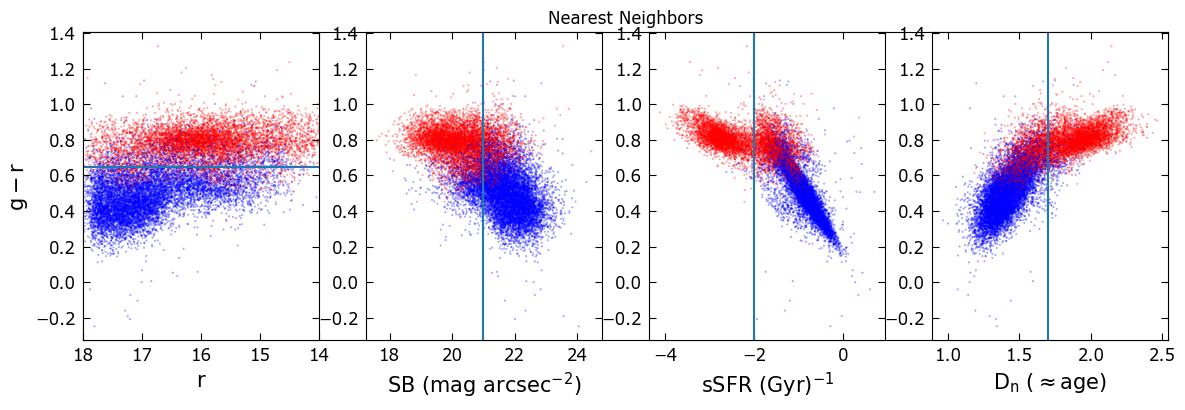

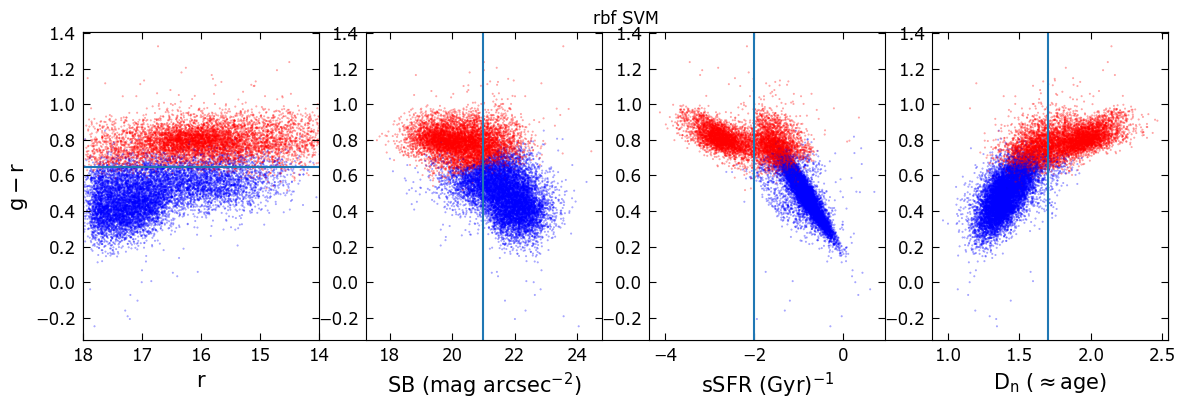

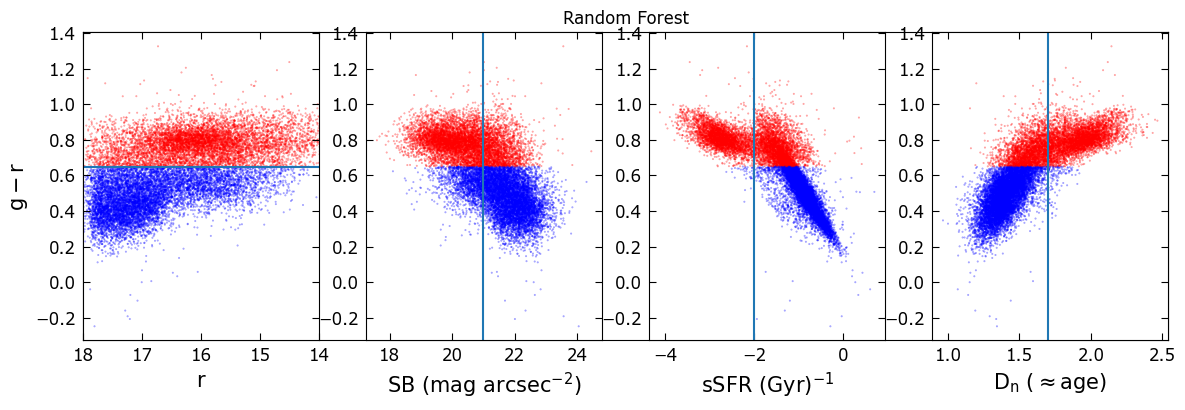

In [27]:
# predict assignments with trained models on new set
yKNN2 = clfKNN.predict(Xnu)
ySVC2 = clfSVC.predict(Xnu)
yRF2 = clfRF.predict(Xnu)

colorsKNN2 = ['red' if label == True else 'blue' for label in yKNN2]
colorsSVC2 = ['red' if label == True else 'blue' for label in ySVC2]
colorsRF2 = ['red' if label == True else 'blue' for label in yRF2]

gd_colors = [colorsKNN2, colorsSVC2, colorsRF2]

for clf, name in zip(gd_colors, names):
    plt.figure(figsize=(14,4))
    plt.title(f'{name}')
    plt.yticks([])
    plt.xticks([])
    for i, plot in zip([0,2,3,4], [1,2,3,4]):
        plt.subplot(1,4, plot)
        plt.scatter(Xnu[:,i], Xnu[:,1], c=clf, alpha=0.4, s=0.2)
        plt.xlabel(r'${\rm r}$')
        if i == 0:
            plt.xlim(18,14)
            # plt.ylim(0,1.2)        
            plt.ylabel(r'${\rm g - r}$')
            plt.axhline(gr_lim)
        if i == 2:
            # plt.ylim(0,1.2)
            plt.axvline(SB_lim)
            plt.xlabel(r'$\mathrm{SB\ (mag\ arcsec^{-2})}$')
        if i == 3:
            # plt.xlim(-4, 1)
            # plt.ylim(0,1.2)
            plt.axvline(sSFR_lim)
            plt.xlabel(r'${\rm sSFR\ (Gyr)^{-1}}$')
        if i == 4:
            # plt.xlim(1, 2.4)
            # plt.ylim(0,1.2)
            plt.axvline(Dn_lim) 
            plt.xlabel(r'$\mathrm{D_n\ (\approx age)}$')

    plt.show()
    print()

## Analysis

I chose to separate the back half of the project into two different target definitions to highlight the benefits of either. The first, including color and specific star formation cuts, favored blue galaxies because having the extra parameter other than color creates more opportunities for bluer classification. In the second, with only the color cut, the color boundaries are defined well across the color vs. different quanities relationships, but a bit too well in most cases. There is a balance between defining only the color of the galaxy and including other qualities of it for this classification, and certain models over-perform depending on the chosen target. Meaning, they assign any point with a certain color to one group of the other, and the other included quanities (sSFR, Dn, SB) seem to be set aside.

* Which numerical methods worked or did not work in this project
    * Gaussian Mixture Modeling
        * The GMM classification was strong across all of the quantities using a 10 group model, and separating them into two classes (red & blue) with the color and specific star formation rate boundary definitions.
    * K Nearest Neighbors
        * For the first target defintion, some blue points are scattered above the color boundary on each plot, with few red points below it. On the unseen data (with p<0.9), the color classification isn't perfect, but the other quantities' boundaries are closer to our expectations than the second target definition.
        * For the second target, the assignments adhere to the color boundary much more closely. On the unseen data, the color separation is much stronger, but the other quantities aren't as clean as the first.
    * Support Vector Machines
        * For the first target definition, a visually equal amount of blue and red points are assigned to the 'wrong' side of the boundary on test set plot. On the unseen data, the sSFR and Dn assignments are strong, but the other two aren't so great.
        * For the second target, few points are incorrectly assigned with respect to the expected boundary on the test set plot. On the unseen data, the color definition takes more control and assigns almost any point above the boundary to red, regardless of the other quantities. 
    * Random Forest
        * For the first target definition, a handful blue points are scattered on top of the color boundary. On the unseen data, the blue points dominate, but the sSFR assignments are quite clean assuming that boundary to be correct.
        * For the second target, no points dare stray from their target assignments on the first plot with the test set. On the unseen data, the color boundary completely takes over and creates a sharp boundary across all of the quantities, which is excessive assignment.
* Lessons learned
    * I got to work with varying classification methods and analyze their assignment accuracy with k-fold cross-validation.
    * The most complex model isn't always the most applicable to every situation, i.e. they all have their benefits and drawbacks.
    * With unsupervised and supervised models, it is important/useful to bring human interpretation to the table and have a good foundation of knowledge on the dataset.
    * The number of GMM groups is pivotal in properly describing the data.
* Further code improvements you could make with significantly more effort
    * Upon further reading into documentation, I found methods to more automatically determine/estimate the hyperparameters & optimize the accuracy, I wouldve liked to use them.
    * I would've liked to experiment with other classification methods.
    * I would've liked to analyze the boundaries of additional attributes of the galaxies in the survey.